# Time Window

## Introduction
In this Jupyter Notebook we determine the best time window reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiments consists of two variables that will be determined:
- The length of the time window
- The start of the time window within the course of a year

## Experiment
To conduct this experiment we assume the following:
- Level-1C Sentinel 2 satellite imagery is used, as Level-2A is available only from 2017 onwards. The QA60 band is used to mask clouds. Besides that only the bands starting with a "B" are used for training and inference.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

We use following results of previous experiments:
- Temporal reducers

## Methodology:

We perform a grid search over the following parameters:
- The length of the time window: 1, 2, 3, 6, 9, 12, 18, and 24 months
- The start of the time window: 1st of every month of the year

We choose the time window for each grid point as early as possible, but not before the 1st of April, 2017. This is because April of 2017 is the first month Sentinel-2 images in Level-2A quality are sattelite started recording around this time.

In [1]:
# Get the list of reducers
import pandas as pd

df = pd.read_csv("../reports/reducers.csv")
reducers = df[df["R2 Score"] > 0]
reducers = list(reducers["Reducer"])

reducers

['circularMean',
 'circularStddev',
 'circularVariance',
 'countDistinctNonNull',
 'countRuns',
 'firstNonNull',
 'kurtosis',
 'lastNonNull',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'sampleStdDev',
 'sampleVariance',
 'skew',
 'stdDev',
 'sum',
 'variance']

In [2]:
from ltm.data import sentinel_composite, list_bands
from ltm.features import load_raster, drop_nan_rows

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

from itertools import product
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
import numpy as np

MONTH = "Month"
LENGTH = "Length"

time_window_path = "../reports/time_window.csv"
if not Path(time_window_path).exists():
    # Define the time windows
    level_2a_start = datetime(2017, 4, 1)
    months = [1]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    window_lengths = [1, 12, 24]  # [1, 2, 3, 6, 9, 12, 18, 24]

    # Define ground truth path and bands
    y_path = "../data/processed/y.tif"
    sentinel_bands = [band for band in list_bands() if band.startswith("B")]

    # Define the scoring metrics
    scoring = {
        "R2 Score": make_scorer(r2_score),
        "Mean Absolute Error": make_scorer(mean_absolute_error),
        "Root Mean Squared Error": make_scorer(mean_squared_error, squared=False),
    }

    # Define the columns
    columns = [MONTH, LENGTH] + list(scoring.keys())

    score_df = pd.DataFrame(columns=columns)
    for month, window_length in product(months, window_lengths):
        start = level_2a_start.replace(month=month)
        if start < level_2a_start:
            start = start.replace(year=start.year + 1)
        end = start + relativedelta(months=window_length)

        X_path = f"../data/processed/time_window/X_{start.strftime('%b')}_{window_length}.tif"
        if not Path(X_path).exists():
            Path(X_path).parent.mkdir(parents=True, exist_ok=True)
            sentinel_composite(
                y_path_from=y_path,
                X_path_to=X_path,
                time_window=(start, end),
                temporal_reducers=reducers,
                sentinel_bands=sentinel_bands,
            )

        # Load the data and drop rows containing NaNs
        X = load_raster(X_path)
        y = load_raster(y_path)
        X, y = drop_nan_rows(X, y)

        # Handle case where less than 5 samples are left (due to 5-fold cross-validation)
        if X.shape[0] < 5:
            score_df.loc[len(score_df.index)] = [
                start.strftime("%B"),
                window_length,
            ] + [np.nan] * len(scoring)
            continue

        # Evaluate the model
        random_forest = RandomForestRegressor(n_jobs=-1, random_state=42)
        scores = cross_validate(random_forest, X, y, scoring=scoring, n_jobs=-1)
        row = [start.strftime("%B"), window_length] + [
            scores[f"test_{key}"].mean() for key in scoring.keys()
        ]
        score_df.loc[len(score_df.index)] = row

    # Save the scores
    score_df.to_csv(time_window_path, index=False)
else:
    score_df = pd.read_csv(time_window_path)

score_df

Initializing Earth Engine API...


,Month,Length,R2 Score,Mean Absolute Error,Root Mean Squared Error
0,January,1,0.517259,0.225950,0.309877
1,January,12,0.513131,0.230490,0.311347
2,January,24,0.505058,0.232957,0.313504


In [3]:
from ltm.features import load_raster

load_raster("../data/processed/time_window/X_Jan_1.tif")

,1 CircularMean B1,1 CircularMean B2,1 CircularMean B3,1 CircularMean B4,1 CircularMean B5,1 CircularMean B6,1 CircularMean B7,1 CircularMean B8,1 CircularMean B8A,1 CircularMean B9,...,1 Variance B3,1 Variance B4,1 Variance B5,1 Variance B6,1 Variance B7,1 Variance B8,1 Variance B8A,1 Variance B9,1 Variance B11,1 Variance B12
0,0.014332,0.024531,0.029465,0.029864,0.059083,0.129667,0.152530,0.182933,0.172547,0.140900,...,0.000584,0.000883,0.000317,0.000499,0.000868,0.000490,0.000826,0.000174,0.000042,0.000079
1,0.018249,0.022748,0.025682,0.030465,0.052866,0.101284,0.118251,0.142367,0.143034,0.124717,...,0.000583,0.000558,0.000409,0.000464,0.000250,0.000207,0.000170,0.000373,0.000064,0.000108
2,0.020082,0.016915,0.020165,0.020882,0.040916,0.081516,0.097983,0.114301,0.120218,0.114732,...,0.000557,0.000502,0.000699,0.000863,0.000515,0.000802,0.000499,0.000598,0.000182,0.000235
3,0.020082,0.013649,0.017348,0.017765,0.031815,0.076499,0.094866,0.094880,0.109667,0.114732,...,0.000595,0.000624,0.000741,0.000769,0.000475,0.000925,0.000497,0.000598,0.000238,0.000354
4,0.020082,0.014849,0.017748,0.017432,0.028165,0.074916,0.093701,0.104682,0.103149,0.114732,...,0.000623,0.000550,0.000763,0.000736,0.000670,0.000705,0.000747,0.000598,0.000320,0.000462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,0.021217,0.019867,0.047083,0.026083,0.102783,0.293184,0.339166,0.354561,0.359754,0.364820,...,0.000002,0.000035,0.000105,0.002935,0.004657,0.003787,0.004960,0.006653,0.002424,0.000214
4328,0.029033,0.027833,0.058717,0.040533,0.118183,0.309936,0.352869,0.353068,0.378176,0.398571,...,0.000019,0.000047,0.000033,0.003128,0.004899,0.004500,0.005411,0.008375,0.002352,0.000061
4329,0.029033,0.026717,0.057383,0.037333,0.118183,0.309936,0.352869,0.389276,0.378176,0.398571,...,0.000002,0.000130,0.000033,0.003128,0.004899,0.007127,0.005411,0.008375,0.002352,0.000061
4330,0.031433,0.026500,0.058617,0.036800,0.124817,0.349457,0.406615,0.419841,0.433240,0.422831,...,0.000001,0.000175,0.000032,0.005510,0.008750,0.008656,0.009558,0.010842,0.001920,0.000074


<Axes: xlabel='Length'>

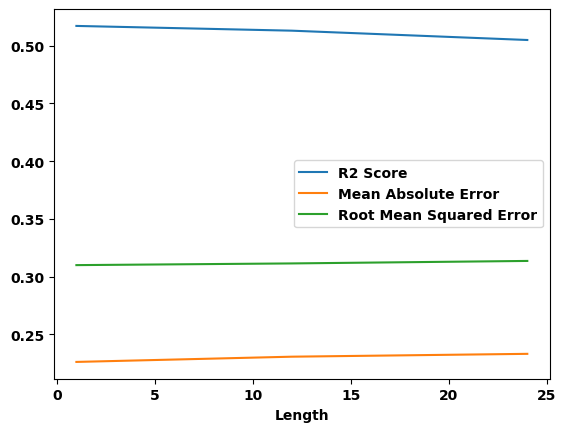

In [4]:
score_df.plot(x="Length")

In [5]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")